In [1]:
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter("ignore")
cnx = sqlite3.connect('data\database.sqlite')

1. Очень часто коллеги упоминают Серию А. Может, она действительно интересная? Посмотрите, сколько там забивают суммарно голов за матч. Постройте гистограмму соответствующего данным типа. Оцените скошенность распределения визуально и подтвердите или опровергните свою гипотезу о скошенности, вычислив среднее, медиану и моду для проверки правила об их соотношении.

In [2]:
#Выберем из базы данных матчи Серии А и количество голов забитых в них
Seria_A = pd.read_sql_query(
'''
select
	leag.name,
	match.home_team_goal + match.away_team_goal as total_goal
from
	League leag
join match match 
on
	leag.id = match.league_id
	and leag.id = 10257
'''
, cnx)

Seria_A.head(3)

,name,total_goal
0,Italy Serie A,1
1,Italy Serie A,5
2,Italy Serie A,1


In [3]:
#Выведем сводную статистику
Seria_A.describe(include = "all")

,name,total_goal
count,3017,3017.000000
unique,1,NaN
top,Italy Serie A,NaN
freq,3017,NaN
mean,NaN,2.616838
std,NaN,1.640327
min,NaN,0.000000
25%,NaN,1.000000
50%,NaN,2.000000
75%,NaN,4.000000


Из полученных данных можно видеть что среднее количество голов за матч - 2.6, а медианное и того меньше - 2

<Axes: >

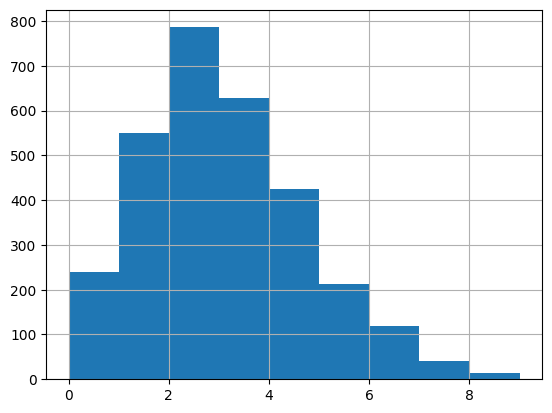

In [4]:
#Построим гистограмму плотности распределния количества голов за матч
Seria_A['total_goal'].hist(bins=9)

Распределени количества голов за матч имеет положительную скошенность

In [5]:
#вычислиv среднее, медиану и моду
print(f"Среднее {Seria_A.total_goal.mean()}")
print(f"Медиана {Seria_A.total_goal.median()}")
print(f"Мода {list(Seria_A.total_goal.mode())}")

Среднее 2.6168379184620485
Медиана 2.0
Мода [2]


Так как среднее больше медианы, распределени количества голов за матч имеет положительную скошенность

2. Не так уж много голов забивается в Серии А, а в каких лигах забивается в среднем голов за матч больше? Выведите их названия.

In [3]:
#Выберем из базы двнных матчи Серии А и количество голов забитых в них
All_Leagues = pd.read_sql_query(
'''
with t1 as (
select	-- Найдем среднее количество голов во всех лигах
	leag.name,
	avg(match.home_team_goal + match.away_team_goal) over (partition by leag.name) mean_goal
from
	League leag
join match match 
on
	leag.id = match.league_id)
select	--Выведем лиги где голов больше чем в Серии А
	name,
	mean_goal 
from
	t1
where
	mean_goal > 2.6168379184620485
group by
	name
order by
	mean_goal desc
'''
, cnx)

All_Leagues

,name,mean_goal
0,Netherlands Eredivisie,3.080882
1,Switzerland Super League,2.929677
2,Germany 1. Bundesliga,2.901552
3,Belgium Jupiler League,2.801505
4,Spain LIGA BBVA,2.767105
5,England Premier League,2.710526
6,Scotland Premier League,2.633772


3. Таких лиг довольно много. Выберем самую интересную лигу и самый интересный сезон в ней. Для этого посчитаем следующие показатели:

- сколько в среднем в каждом сезоне каждой лиги забивалось суммарно голов командами за матч

- сколько в среднем матчей за сезон заканчивались победой, а не ничьей.

In [4]:
# Найдем среднее количество голов за сезон во всех лигах
All_Leagues_season_goal = pd.read_sql_query(
    '''
    select	
    leag.name || ' (' || match.season || ')' as leag_season,
	avg(match.home_team_goal + match.away_team_goal) as avg_goal
    from
	League leag
join match match 
on
	leag.id = match.league_id
group by leag.name, match.season
order by avg_goal desc
    '''
    , cnx)

All_Leagues_season_goal

,leag_season,avg_goal
0,Switzerland Super League (2009/2010),3.327778
1,Netherlands Eredivisie (2011/2012),3.258170
2,Netherlands Eredivisie (2010/2011),3.225490
3,Netherlands Eredivisie (2013/2014),3.196078
4,Germany 1. Bundesliga (2013/2014),3.160131
...,...,...
83,Portugal Liga ZON Sagres (2008/2009),2.300000
84,France Ligue 1 (2008/2009),2.257895
85,Poland Ekstraklasa (2009/2010),2.216667
86,Poland Ekstraklasa (2011/2012),2.195833


In [12]:
# Найдем количество побед за сезон во всех лигах
All_Leagues_season_win = pd.read_sql_query(
'''
with t1 as (
select	
	leag.name || ' (' || match.season || ')' as leag_season,
    case
		when match.home_team_goal <> match.away_team_goal
        then 1
		else 0
	end as win
from
	League leag
join match match 
on
	leag.id = match.league_id),
t2 as (
select *,
avg(win) over (partition by leag_season) avg_win
from t1
)
select	
	leag_season,
    avg_win 
from
	t2
where
	win = 1    
group by leag_season
order by
	avg_win desc
'''
, cnx)

All_Leagues_season_win

,leag_season,avg_win
0,Switzerland Super League (2009/2010),0.838889
1,Belgium Jupiler League (2013/2014),0.833333
2,Scotland Premier League (2014/2015),0.807018
3,Netherlands Eredivisie (2009/2010),0.797386
4,England Premier League (2013/2014),0.794737
...,...,...
83,Poland Ekstraklasa (2013/2014),0.695833
84,Poland Ekstraklasa (2015/2016),0.691667
85,Italy Serie A (2014/2015),0.683377
86,Scotland Premier League (2012/2013),0.679825


4. Для каждого из двух показателей, рассчитанных в предыдущем шаге, выведите, какой сезон какой лиги по нему самый зрелищный.

In [9]:
print('Максимальное средннее количество голов  в сезоне:')
All_Leagues_season_goal.nlargest(1, 'avg_goal')[['leag_season', 'avg_goal']]


Максимальное средннее количество голов  в сезоне:


,leag_season,avg_goal
0,Switzerland Super League (2009/2010),3.327778


In [10]:
print('Максимальное количество матчей, завершившихся победой одной из команд в сезоне:')
All_Leagues_season_win.nlargest(1, 'avg_win')[['leag_season', 'avg_win']]


Максимальное количество матчей, завершившихся победой одной из команд в сезоне:


,leag_season,avg_win
0,Switzerland Super League (2009/2010),0.838889


5. Насколько показатели, рассчитанных в шаге 3, взаимосвязаны? Оцените их корреляцию и постройте для них диаграмму рассеивания, чтобы ответить на этот вопрос.

In [13]:
All_Leagues_season = All_Leagues_season_win.merge(All_Leagues_season_goal, on='leag_season')
All_Leagues_season.corr(numeric_only = True)

,avg_win,avg_goal
avg_win,1.000000,0.358269
avg_goal,0.358269,1.000000


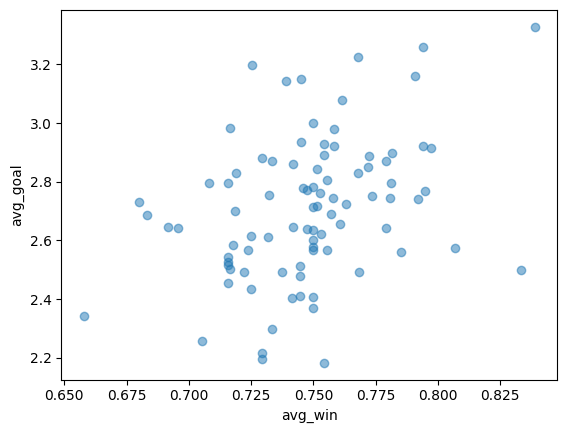

In [16]:
plt.scatter(All_Leagues_season['avg_win'], All_Leagues_season['avg_goal'], alpha=0.5)
plt.xlabel('avg_win')
plt.ylabel('avg_goal')
plt.show;

Корреляция среднего количества голов за матч в сезоне и количества побед в сезоне близка к 0, т.е. отсутствует

6. Выберите лигу, в которой самый интересный сезон. Чтобы разобраться в правилах футбола и не заскучать, посмотрим именно этот сезон! 

In [14]:
#Выберем из базы данных матчи England Premier League (2013/2014) и количество голов забитых в них
EPL = pd.read_sql_query(
'''
select
	leag.name,
    match.season,
	match.home_team_goal,
    match.away_team_goal,
    match.home_team_goal + match.away_team_goal as total_goal
from
	League leag
join match match 
on
	leag.id = match.league_id
	and leag.id = 1729 
    and match.season = '2013/2014'
    
'''
, cnx)
EPL

,name,season,home_team_goal,away_team_goal,total_goal
0,England Premier League,2013/2014,1,3,4
1,England Premier League,2013/2014,2,0,2
2,England Premier League,2013/2014,0,1,1
3,England Premier League,2013/2014,1,0,1
4,England Premier League,2013/2014,4,0,4
...,...,...,...,...,...
375,England Premier League,2013/2014,0,0,0
376,England Premier League,2013/2014,2,0,2
377,England Premier League,2013/2014,2,1,3
378,England Premier League,2013/2014,1,0,1


7. Интересно, а можно ли гарантировать, что в этой лиге всегда такой интересный футбол? Оцените математическое ожидание и стандартное отклонение среднего количества голов за матч с помощью имеющейся выборки. Затем постройте ящик с усами. И сделайте вывод, можно ли быть уверенным, что матчи в этой лиге всегда результативные.

In [15]:
print(f'Математическое ожидание = {EPL.total_goal.mean()}')

Математическое ожидание = 2.768421052631579


In [16]:
print(f'Стандартное отклонение = {EPL.total_goal.std()}')

Стандартное отклонение = 1.7325237837608585


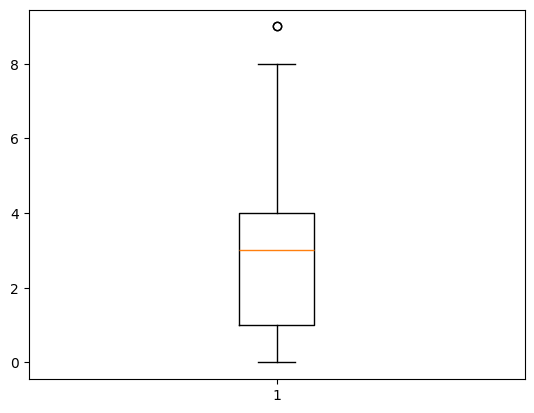

In [17]:
bxplt = plt.boxplot(EPL.total_goal);

Из полученных данных можно сделать вывод, что наиболее вероятная результативность матчей находится в диапазоне от 1 до 4 голов за матч